### Micrograd

**Node Class**

In [1]:
class Node:
    def __init__(self, value=0.0, grad=0.0, parents=[], op="", backward_fn=None):
        self.value = value
        self.grad = grad
        self.parents = parents
        self.op = op
        self.backward_fn = backward_fn

    def __add__(self, node):
        if not isinstance(node, Node):
            return NotImplemented
        sum_node = Node(
            self.value + node.value,
            0.0, #Initially 0, its value will be provided by its child.
            [self, node],
            "sum",
        )

        def _backward_fn():
            """
                This method allows the new node to assign the correct network gradient for its parents.
                sum_node = this_node + node
                this_node.gradient = sum_node*1 -> this_node.gradeient += sum_node
                node.gradient = sum_node*1 -> this_node.gradient += sum_node
            """
            if sum_node.grad is None:
                raise ValueError
            for parent in sum_node.parents:
                parent.grad += sum_node.grad
        
        sum_node.backward_fn = _backward_fn
        return sum_node
    
    def __mul__(self, node):
        """
        Product rule: if mul_node = parent[0] * parent[1], then:
        parent[0].grad += mul_node.grad * parent[1].value
        parent[1].grad += mul_node.grad * parent[0].value
        """
        if not isinstance(node, Node):
            return NotImplemented
        mul_node = Node(
            self.value * node.value, 
            0.0, #Initially 0, its value will be provided by its child.
            [self, node],
            "mul",
        )

        def _backward_fn():
            if mul_node.grad is None:
                raise ValueError
            mul_node.parents[0].grad += mul_node.grad*mul_node.parents[1].value
            mul_node.parents[1].grad += mul_node.grad*mul_node.parents[0].value

        mul_node.backward_fn=_backward_fn
        return mul_node
    
    def __pow__(self, value):
        pow_node = Node(
            self.value**value,
            0.0,
            [self],
            "pow"
        )
        
        def _backward():
            if pow_node.grad is None:
                raise ValueError
            pow_node.parents[0].grad += pow_node.grad * (value*self.value**(value - 1))
        pow_node.backward_fn = _backward

        return pow_node
    
    def __neg__(self):
        neg_node = Node(
            -self.value,
            0.0,
            [self],
            "neg"
        )

        def _backward():
            if neg_node.grad is None:
                raise ValueError
            neg_node.parents[0].grad += -neg_node.grad
        neg_node.backward_fn = _backward

        return neg_node 

    def relu(self):
        relu_node = Node(
            max(0, self.value),
            0.0,
            [self],
            "relu"
        )

        def _backward_fn():
            if relu_node.grad is None:
                raise ValueError
            relu_node.parents[0].grad += 0 if self.value <= 0 else relu_node.grad
        
        relu_node.backward_fn = _backward_fn
        return relu_node

    def backward(self):
        self.grad = 1
        visited = set()
        topological_order = list()
        def dfs(node: Node, visited: set, nodes_list: list):
            if node in visited:
                return
            visited.add(node)
            for parent in node.parents:
                dfs(parent, visited, nodes_list)

            nodes_list.append(node)

        dfs(self, visited, topological_order)

        topological_order.reverse()

        for node in topological_order:
            if node.backward_fn is not None:
                node.backward_fn()




**Test y=2*x + 3**

In [4]:
training_set = [1, 2, 5, 7, 0, 6, 12, 15, 18]

training_set_label = [5, 7, 13, 17, 3, 15, 27, 33, 39]

test_set = [11, 22, 14]

test_set_label = [25, 47, 31]
w = Node(0.5)
b = Node(1.0)

parameters = [w, b]
for epoch in range(100):
    total_loss = 0
    for value, y_target in zip(training_set, training_set_label):
        for parameter in parameters:
            parameter.grad = 0.0
        i = Node(float(value))
        y_pred = w*i + b
        loss = (y_pred + (-Node(float(y_target))))**2
        total_loss += loss.value
        loss.backward()
        for parameter in parameters:
            parameter.value -= 0.001*parameter.grad
    
    print(total_loss/len(training_set_label))


90.62308039576764
2.8270311380123876
1.4408295356772396
1.3662714626759476
1.3416938508755347
1.321651970553542
1.3023331927871098
1.2833415509765842
1.2646315968591972
1.2461949183633054
1.2280270756769651
1.2101241012775725
1.1924821286342293
1.1750973521533903
1.157966022205614
1.1410844438772036
1.12444897612672
1.108056030994761
1.0919020728295772
1.0759836175244506
1.0602972317662251
1.0448395322948072
1.0296071851734536
1.0145969050697212
0.9998054545468579
0.9852296433655631
0.9708663277959205
0.9567124099393298
0.9427648370603701
0.9290206009283671
0.9154767371685938
0.9021303246228807
0.8889784847196088
0.8760183808528228
0.8632472177704635
0.8506622409714508
0.8382607361116141
0.8260400284182459
0.813997482113203
0.8021304998444299
0.7904365221257479
0.7789130267848233
0.7675575284191835
0.7563675778601658
0.7453407616446674
0.7344747014946171
0.7237670538040252
0.7132155091334993
0.7028177917121516
0.692571658946761
0.682474900938075
0.6725253400041922
0.6627208302108557
0.

In [5]:
correct = 0
tolerance = 1.0

for x, y in zip(test_set, test_set_label):
    x = Node(float(x))
    y_pred = w*x + b

    if y_pred.value >= (y - tolerance) or y_pred <= (y + tolerance):
        correct+=1

print(f"accuracy: {correct/len(test_set_label)}")


x = Node(26.0)
y_pred = w*x + b

print(y_pred.value)

accuracy: 1.0
55.57209296819429


C:\Users\jc025\AppData\Local\Temp\ipykernel_8080\391527027.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


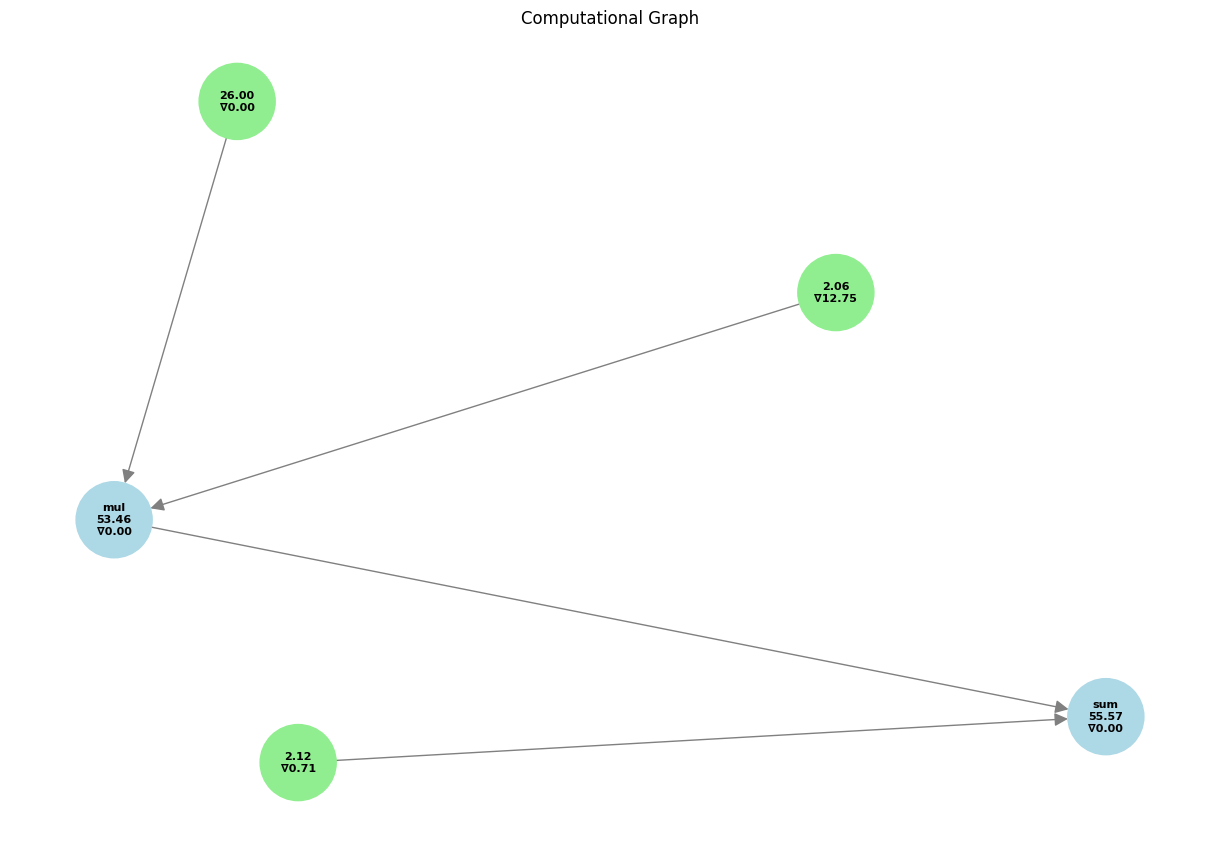

Grafo salvato in computational_graph.png
